In [1]:
import numpy as np 
import pandas as pd 
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', sep = ';', header=None)
df.columns = ['text', 'emotion']
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df.emotion.value_counts()

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [4]:
df['sentiment'] = df.emotion.map({'joy':1, 'sadness':2, 'anger':3, 'fear':4, 'love':5, 'surprise':6})
df.head()

,text,emotion,sentiment
0,i didnt feel humiliated,sadness,2
1,i can go from feeling so hopeless to so damned...,sadness,2
2,im grabbing a minute to post i feel greedy wrong,anger,3
3,i am ever feeling nostalgic about the fireplac...,love,5
4,i am feeling grouchy,anger,3


## Preprocessing 

In [5]:
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [6]:
df['preprocessed_text'] = df.text.apply(preprocess)
df.head()

,text,emotion,sentiment,preprocessed_text
0,i didnt feel humiliated,sadness,2,not feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,2,feel hopeless damned hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,3,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,5,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,3,feel grouchy


## ML Pipeline

In [7]:
X = df.preprocessed_text
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pipe1 = Pipeline([
    ('vectorizer_uni_bi', CountVectorizer(ngram_range = (1, 2))),
    ('randomForest', RandomForestClassifier())
])
pipe1.fit(X_train, y_train)
y_pred = pipe1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.92      0.90      1021
           2       0.88      0.93      0.90       946
           3       0.87      0.85      0.86       427
           4       0.90      0.79      0.84       397
           5       0.83      0.71      0.77       296
           6       0.75      0.73      0.74       113

    accuracy                           0.87      3200
   macro avg       0.85      0.82      0.83      3200
weighted avg       0.87      0.87      0.87      3200



In [9]:
pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('randomForest', RandomForestClassifier())
])
pipe2.fit(X_train, y_train)
y_pred = pipe2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.92      0.87      1021
           2       0.91      0.88      0.90       946
           3       0.85      0.84      0.84       427
           4       0.85      0.82      0.84       397
           5       0.81      0.64      0.71       296
           6       0.78      0.67      0.72       113

    accuracy                           0.85      3200
   macro avg       0.84      0.80      0.81      3200
weighted avg       0.85      0.85      0.85      3200



In [10]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='all')
X_sm, y_sm = smote.fit_resample(X_vec, y)

y_sm.value_counts()

sentiment
2    5362
3    5362
5    5362
6    5362
4    5362
1    5362
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.88      0.87      1078
           2       0.95      0.85      0.90      1087
           3       0.94      0.96      0.95      1054
           4       0.96      0.95      0.95      1051
           5       0.93      0.97      0.95      1092
           6       0.97      1.00      0.98      1073

    accuracy                           0.93      6435
   macro avg       0.93      0.93      0.93      6435
weighted avg       0.93      0.93      0.93      6435



## Final Training

In [13]:
pipe1 = Pipeline([
    ('vectorizer_uni_bi', CountVectorizer(ngram_range = (1, 2))),
    ('randomForest', RandomForestClassifier())
])
pipe1.fit(X, y)

Pipeline(steps=[('vectorizer_uni_bi', CountVectorizer(ngram_range=(1, 2))),
                ('randomForest', RandomForestClassifier())])

## Testing

Getting the Test Data

In [14]:
df_test = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', sep = ';', header=None)
df_test.columns = ['text', 'emotion']
df_test['sentiment'] = df_test.emotion.map({'joy':1, 'sadness':2, 'anger':3, 'fear':4, 'love':5, 'surprise':6})
df_test['preprocessed_text'] = df_test.text.apply(preprocess)
df_test.head()

,text,emotion,sentiment,preprocessed_text
0,im feeling rather rotten so im not very ambiti...,sadness,2,m feel rotten m ambitious right
1,im updating my blog because i feel shitty,sadness,2,m update blog feel shitty
2,i never make her separate from me because i do...,sadness,2,separate don t want feel like m ashamed
3,i left with my bouquet of red and yellow tulip...,joy,1,leave bouquet red yellow tulip arm feel slight...
4,i was feeling a little vain when i did this one,sadness,2,feel little vain


In [15]:
y_pred = pipe1.predict(df_test['preprocessed_text'])
print(classification_report(df_test['sentiment'], y_pred))

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       695
           2       0.89      0.94      0.91       581
           3       0.88      0.85      0.87       275
           4       0.90      0.83      0.86       224
           5       0.75      0.65      0.70       159
           6       0.73      0.61      0.66        66

    accuracy                           0.87      2000
   macro avg       0.84      0.80      0.82      2000
weighted avg       0.87      0.87      0.87      2000



<Axes: >

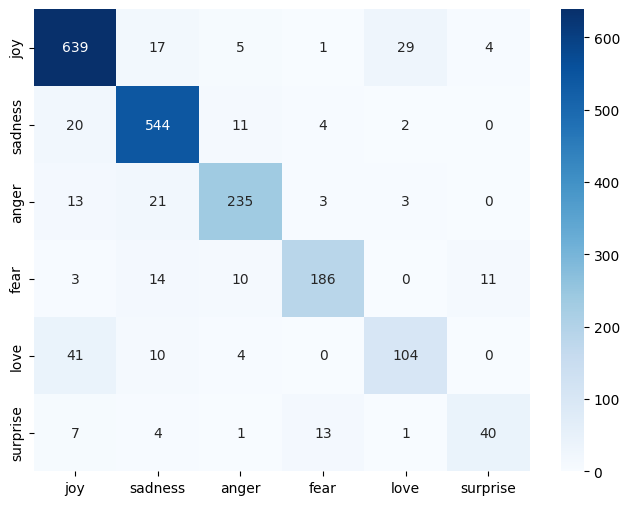

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  confusion_matrix
plt.figure(figsize=(8,6))
emotions = {'joy':1, 'sadness':2, 'anger':3, 'fear':4, 'love':5, 'surprise':6}
emotions = list(emotions.keys())
cm = confusion_matrix(df_test['sentiment'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

## Saving the model

In [17]:
import pickle
pickle.dump(pipe1, open('model.pkl','wb'))

## Validation Check

In [18]:
model = pickle.load(open('model.pkl','rb'))

              precision    recall  f1-score   support

           1       0.92      0.91      0.92       704
           2       0.87      0.96      0.91       550
           3       0.89      0.88      0.89       275
           4       0.91      0.79      0.85       212
           5       0.84      0.74      0.79       178
           6       0.81      0.74      0.77        81

    accuracy                           0.89      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.89      0.89      0.89      2000



<Axes: >

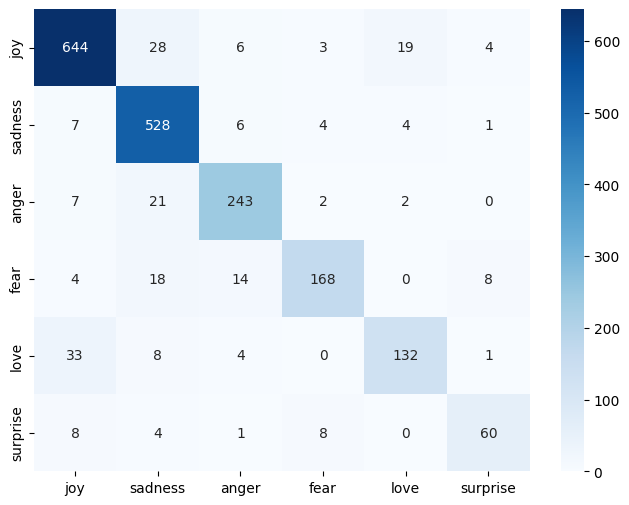

In [19]:
df_val = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', sep = ';', header=None)
df_val.columns = ['text', 'emotion']
df_val['sentiment'] = df_val.emotion.map({'joy':1, 'sadness':2, 'anger':3, 'fear':4, 'love':5, 'surprise':6})
df_val['preprocessed_text'] = df_val.text.apply(preprocess)

y_pred = model.predict(df_val['preprocessed_text'])
print(classification_report(df_val['sentiment'], y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  confusion_matrix
plt.figure(figsize=(8,6))
emotions = {'joy':1, 'sadness':2, 'anger':3, 'fear':4, 'love':5, 'surprise':6}
emotions = list(emotions.keys())
cm = confusion_matrix(df_val['sentiment'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)